# 2022-05-02• STA mean vs peak-to-peak

Peak-to-peak cannot distinguish excitatory vs inhibitory (it's just the height of the bump -- no matter whether it's upwards or downwards).

To do that, we might instead use sth like "either max-median or min-median, whatever's largest in absolute terms".

For now we don't try to detect this difference, and 'cheat' in our code (special-case the inhibitory / ptp case when comparing p-values with α).

## Setup

In [1]:
#

In [2]:
using Revise

In [3]:
using MyToolbox

In [9]:
using VoltageToMap

[ Info: Precompiling VoltageToMap [b3b8fdc5-3c26-4000-a0c8-f17415fdf48e]


In [5]:
using PyPlot
using VoltageToMap.Plot

[ Info: Precompiling Sciplotlib [61be95e5-9550-4d5f-a203-92a5acbc3116]


## Params

In [4]:
N_excs = [
    4,   # => N_inh = 1
    17,  # Same as in `previous_N_30_input`.
    80,
    320,
    1280,
    5200,  
];

In [30]:
rngseeds = [0:16;];

In [34]:
get_params((N_exc, STA_test_statistic, rngseed)) = ExperimentParams(
    sim = SimParams(
        duration = 10 * minutes,
        imaging = get_VI_params_for(cortical_RS, spike_SNR = Inf),
        input = PoissonInputParams(; N_exc);
        rngseed,
    ),
    conntest = ConnTestParams(; STA_test_statistic, rngseed);
    evaluation = EvaluationParams(; rngseed)
);

In [45]:
variableparams = collect(product(N_excs, ["ptp", "mean"], rngseeds));

In [36]:
paramsets = get_params.(variableparams);
print(summary(paramsets))

6×2×17 Array{ExperimentParams, 3}

In [37]:
dumps(paramsets[1])

ExperimentParams
  sim: SimParams
    duration: 600.0
    Δt: 0.0001
    num_timesteps: 6000000
    rngseed: 0
    input: PoissonInputParams
      N_unconn: 100
      N_exc: 4
      N_inh: 1
      N_conn: 5
      N: 105
      spike_rates: LogNormal
        μ: 1.08629
        σ: 0.774597
    synapses: SynapseParams
      avg_stim_rate_exc: 1.0e-10
      avg_stim_rate_inh: 4.0e-10
      E_exc: 0.0
      E_inh: -0.065
      g_t0: 0.0
      τ: 0.007
    izh_neuron: IzhikevichParams
      C: 1.0e-10
      k: 7.0e-7
      v_rest: -0.06
      v_thr: -0.04
      a: 30.0
      b: -2.0e-9
      v_peak: 0.035
      v_reset: -0.05
      Δu: 1.0e-10
      v_t0: -0.06
      u_t0: 0.0
    imaging: VoltageImagingParams
      spike_SNR: Inf
      spike_SNR_dB: Inf
      spike_height: 0.095
      σ_noise: 0.0
  conntest: ConnTestParams
    STA_window_length: 0.1
    num_shuffles: 100
    STA_test_statistic: ptp
    rngseed: 0
  evaluation: EvaluationParams
    α: 0.05
    num_tested_neurons_per_group: 4

## Run

In [ ]:
perfs = similar(paramsets, NamedTuple)
for i in eachindex(paramsets)
    (N_exc, stat, seed) = variableparams[i]
    paramset = paramsets[i]
    println((; N_exc, stat, seed), " ", cachefilename(paramset))
    perf = cached(sim_and_eval, [paramset])
    perfs[i] = perf
end

- `sim` cache (10' x 6 N x 4 seeds): 3GB
    - 95 à 142MB per 10' sim
- `perf` cache: 0.3MB -- so that could go in git

## Prepare plot

We want to plot dots.
We can either have  
`N = [5, 21]`  
and `TPR_exc = [1 .9 1; .8 .7 .8]` (matrix notation. 3 seeds).  
or  
`N = [5, 5, 5, 21, 21, 21]` (i.e. repeat)  
and `TPR_exc = [1, .9, 1, .8, .7, .8]`.

In [39]:
"""
Create an array of the same shape as the one given, but with just
the values stored under `name` in each element of the given array.
"""
function extract(name::Symbol, arr #=an array of NamedTuples or structs =#)
    getval(index) = getproperty(arr[index], name)
    out = similar(arr, typeof(getval(firstindex(arr))))
    for index in eachindex(arr)
        out[index] = getval(index)
    end
    return out
end;

In [ ]:
extract(:TPR_exc, perfs);

In [41]:
import PyPlot

[ Info: Precompiling Sciplotlib [61be95e5-9550-4d5f-a203-92a5acbc3116]


In [42]:
using VoltageToMap.Plot

In [45]:
function make_figure(perfs)
    xticklabels = [p.sim.input.N_conn for p in paramsets[:,1,1]]
    xs = [1:length(xticklabels);]
    fig, ax = plt.subplots()
    plot_detection_rate(rate; kw...) = plot_samples_and_means(xs, rate, ax; kw...)
    plot_detection_rate(extract(:TPR_exc, perfs), label="for excitatory inputs", c=color_exc)
    plot_detection_rate(extract(:TPR_inh, perfs), label="for inhibitory inputs", c=color_inh)
    plot_detection_rate(extract(:FPR, perfs), label="for unconnected spikers", c=color_unconn)
    
    set(ax; xtype=:categorical, ytype=:fraction, xticklabels, xlabel="Number of connected inputs")
    
    add_α_line(ax, paramsets[1].evaluation.α)
    
    l = ax.legend(title="Detection rate", ncol=2, loc="lower right", bbox_to_anchor=(1.06, 1.1))
    l._legend_box.align = "left"
    return fig, ax
end;

## Plot

### Peak-to-peak

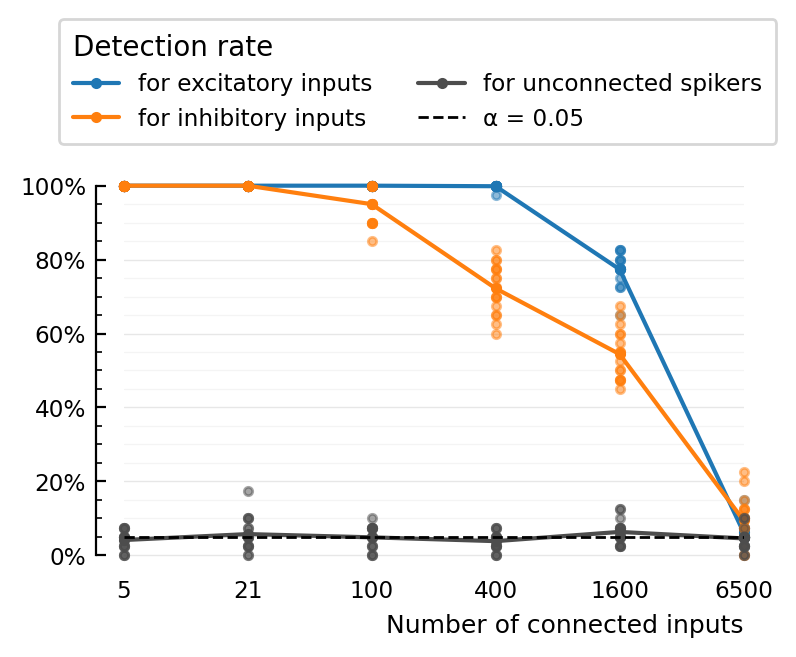

In [54]:
fig, ax = make_figure(perfs[:,1,:]);

### Mean

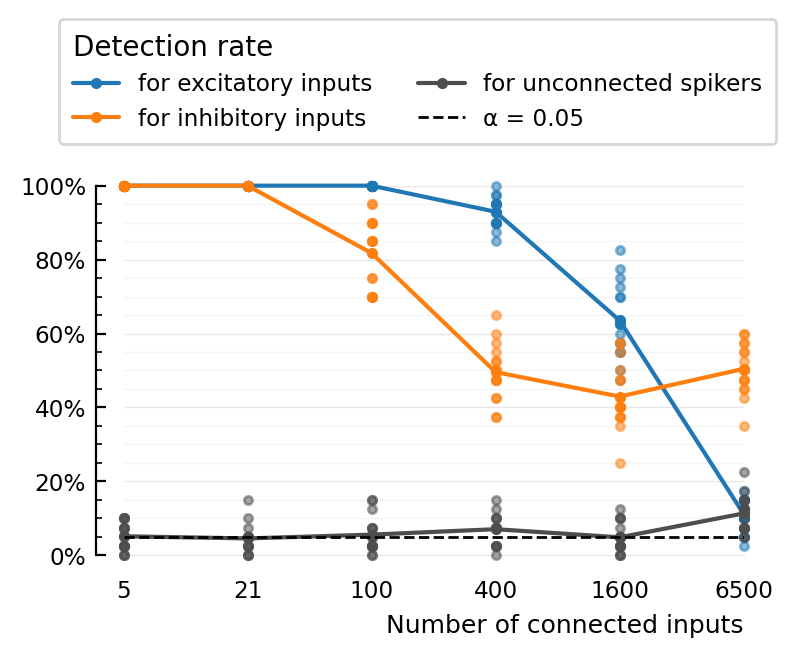

In [55]:
fig, ax = make_figure(perfs[:,2,:]);